In [6]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
import torch.nn.functional as F
from Datasets import dataset 
import os 
from torch.utils.tensorboard import SummaryWriter 
import shutil
from DataLoaders import DataLoader


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def set_random_seed(random_seed=None):
    if random_seed is None:
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {random_seed}")

In [9]:
set_random_seed()

Random seed set to: 13


In [10]:
transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_2 = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

color_jitter = transforms.ColorJitter(
    brightness=0.4,  # Adjust brightness by ±40%
    contrast=0.4,    # Adjust contrast by ±40%
    saturation=0.4,  # Adjust saturation by ±40%
    hue=0.1          # Adjust hue by ±10%
)
transform_3 = transforms.Compose([
    transforms.Resize((250, 250)),
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
train_ds =dataset(root = "images/",transform=transform_1, split = "train")
test_ds =dataset(root = "images/",transform=transform_1, split = "test")
classes = ("Robots", "Humans")
print(f"train size :{train_ds.__len__()} \n test size :{test_ds.__len__()} ")

train size :339 
 test size :146 


In [12]:
trainloader = DataLoader(train_ds, batch_size=32, shuffle=True,num_classes = 2,augmentation = "CutMix",alpha = 2.0 )
testloader = DataLoader(test_ds, batch_size=32, shuffle=False, num_classes =2 )
class_names = ["Humans", "Robots"]

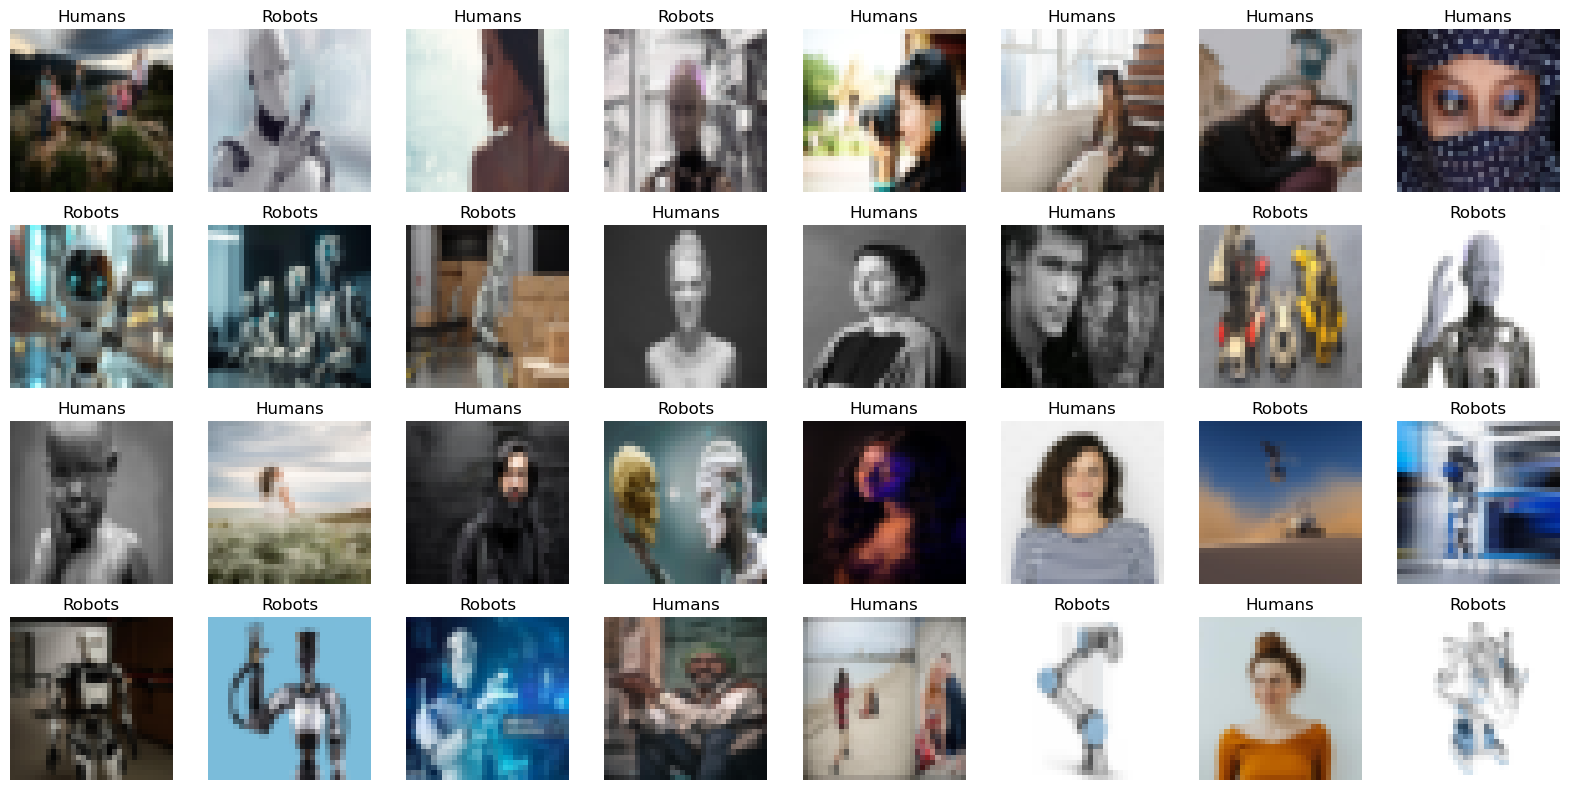

In [13]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    data = std * data + mean 
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
inputs, classes = next(iter(testloader))
titles = [class_names[x] for x in classes]

show_grid(inputs,titles)

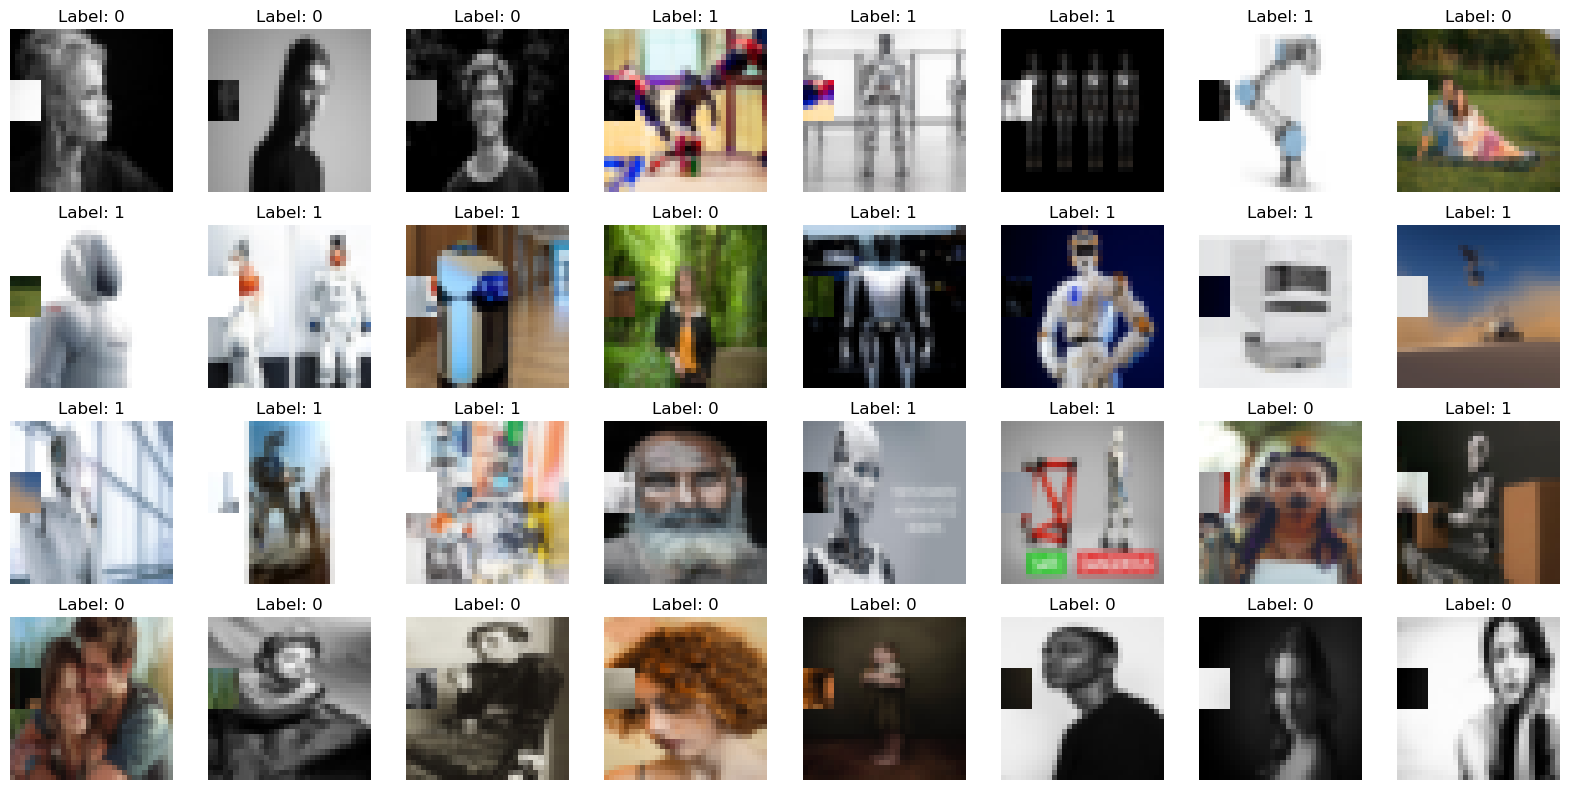

In [14]:
# Fetch a batch of data
inputs, labels = next(iter(trainloader))
# Visualize
show_grid(inputs.cpu(), [f"Label: {lbl}" for lbl in labels.argmax(dim=1)])


In [17]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNNs", "CNN_tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [18]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(128 * 8 * 8, 64)  # Fully connected layer
        self.fc2 = torch.nn.Linear(64, 2)  # 10 output classes for CIFAR-10
        return
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
model = CNN_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,writer = writer)
train.train(5,trainloader,testloader,classes)
writer.close()

Epoch 5 Iter 11: loss 0.61428.: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


In [25]:
train.valid_accuracy()

Validation accuracy: 78.08%


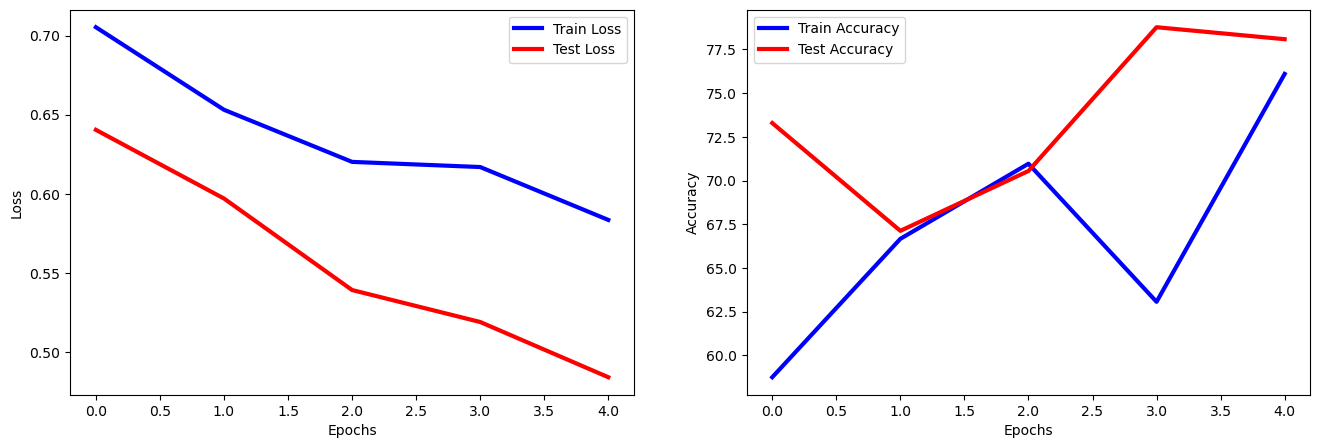

In [26]:
train.plot_loss_acc()

## ResNet18

In [28]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNNs", "ResNet18")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [29]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [30]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

In [31]:
resnet18.to(device)
resnet18.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
train = Wrapper(model = resnet18,device = device, criterion = criterion, optimizer = optimizer,writer=writer)
train.train(10,trainloader,testloader,classes)
writer.close()

Epoch 10 Iter 11: loss 0.61022.: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Validation accuracy: 88.36%


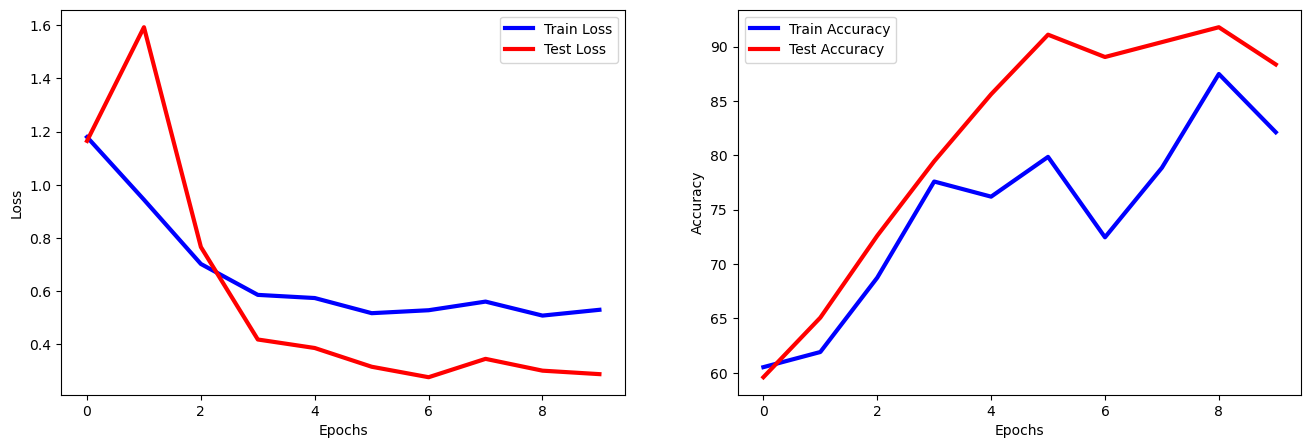

In [34]:
train.valid_accuracy()
train.plot_loss_acc()

## SqueezeNet

In [35]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNNs", "SqueezNet")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [36]:
squeezeNet = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)

In [37]:
squeezeNet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

In [38]:
squeezeNet.to(device)
squeezeNet.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezeNet.parameters(), lr=0.001)
train = Wrapper(model = squeezeNet,device = device, criterion = criterion, optimizer = optimizer,writer=writer)
train.train(10,trainloader,testloader,classes)
writer.close()

Epoch 10 Iter 11: loss 0.69315.: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Validation accuracy: 51.37%


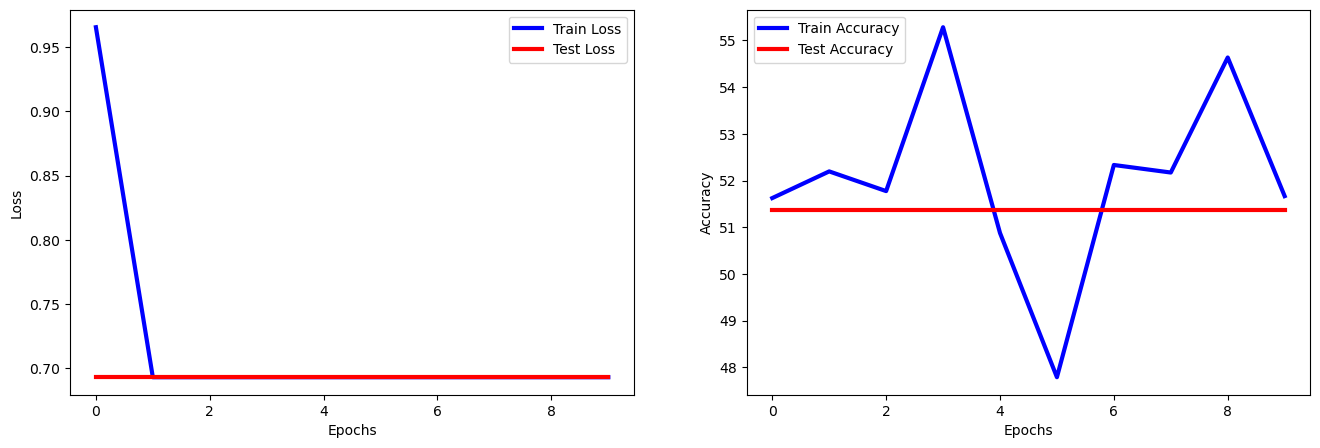

In [42]:
train.valid_accuracy()
train.plot_loss_acc()

## ConvNext

In [43]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNNs", "ConvNext")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [44]:
convNext = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /home/s93yelwa/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:03<00:00, 114MB/s]  


In [45]:
convNext.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

In [46]:
convNext.to(device)
convNext.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNext.parameters(), lr=0.001)
train = Wrapper(model = convNext,device = device, criterion = criterion, optimizer = optimizer,writer=writer)
train.train(10,trainloader,testloader,classes)
writer.close()

Epoch 10 Iter 11: loss 0.74112.: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Validation accuracy: 71.92%


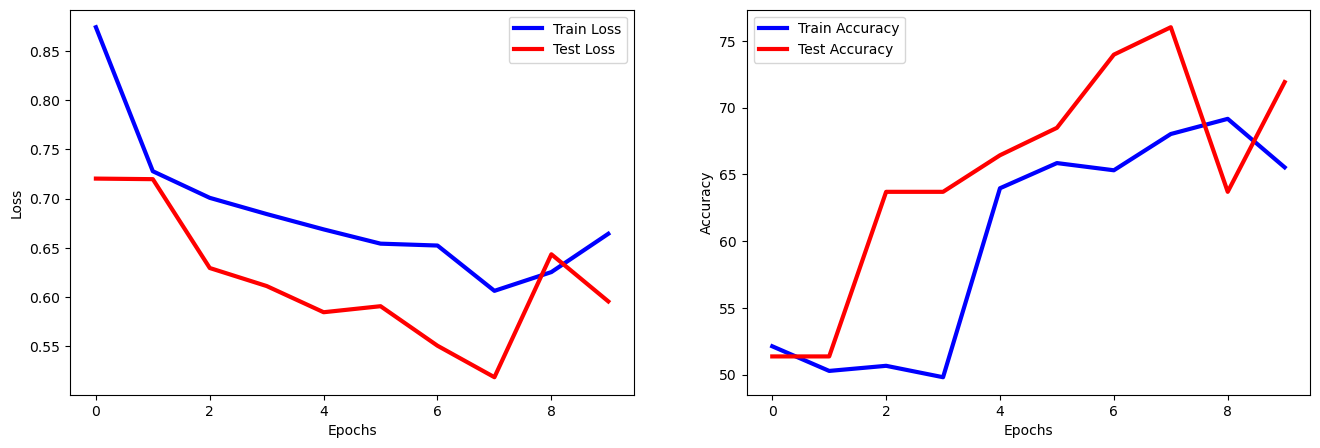

In [47]:
train.valid_accuracy()
train.plot_loss_acc()